# Image Feature Extraction Using VGG16 Model

**This notebook runs locally**

Image feature extraction using VGG16 models, clustering with k-means and evaluation of different parameters: image size, greyscaling, segmentation, dimensionality reduction with PCA and fine-tuning.

This notebook requires:
* Pre-processed CSV file using [data_exploration_and_cleaning.ipynb](data_exploration_and_cleaning.ipynb)
* Raw images
* Segmented images (two segmentation rounds)

## Load Dependencies

In [1]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
print('TF Version:', tf.__version__)
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input # The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

import os
import pandas as pd
%matplotlib inline

2024-02-21 12:17:21.319125: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-21 12:17:21.677251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 12:17:21.677297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 12:17:21.738168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 12:17:21.856221: I tensorflow/core/platform/cpu_feature_guar

TF Version: 2.15.0


In [3]:
%load_ext autoreload
%autoreload 2
    
# import helper functions
import sys
sys.path.append("../../src")
from image_feature_extraction_clustering_evaluation_workflow_ria import run
from image_feature_extraction import load_from_pickle_file
import visualization as vis

In [4]:
physical_gpus = tf.config.experimental.list_physical_devices('GPU')

if physical_gpus:
    print("Number of available GPUs:", len(physical_gpus))
    for gpu in physical_gpus:
        print("GPU name:", gpu.name)
else:
    print("No GPUs found.")

Number of available GPUs: 1
GPU name: /physical_device:GPU:0


2024-02-21 12:17:26.047986: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 12:17:26.317184: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 12:17:26.317548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [5]:
!nvidia-smi

Wed Feb 21 12:17:26 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.01   Driver Version: 529.19       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A300...  On   | 00000000:01:00.0  On |                  N/A |
| N/A   53C    P8    16W /  80W |    576MiB /  6144MiB |     38%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Constants
processed_data_folder = '../../data/processed'
csv_file = 'SyrusMasterDataAnonymisedProc.csv'
models_folder = '../../models'
raw_images = '../../data/raw/SyrusImage'
segmented_images_round1 = '../../data/processed/SyrusImageSegmentedPartJoined'
segmented_images = '../../data/processed/SyrusImageSegmented'
pretrained_model_image_size = (224, 224)
finetuned_model_image_size_mode = (353, 500) # mode image size calculated in the notebook data_exploration_and_cleaning.ipynb
finetuned_model_image_size_mean = (475, 613) # mean image size calculated in the notebook data_exploration_and_cleaning.ipynb

In [7]:
# Parameters
# same for the whole notebook:
model_name = 'vgg16'
# If not set below, using the default:
target_size = None # use original image size
grayscale = False
n_components = None # for PCA
pca_var = None # cumulative explained variance for finding the number of components for PCA
n_clusters = 500
reports_subfolder = None #for saving clustered images use: f"{model_details}_pca{n_components}_kmeans{n_clusters}"
threshold = 0.7 # for evaluation
evaluate_n_clusters = False # for evaluation with different number of clusters

## Prepare the models
The simplest is to use the model with images resized to a fixed image size that was used for pretraining the model.
For this, we load the model and remove the output layer. This means that the new final layer is a fully-connected layer with x output nodes. This vector of x numbers is the feature vector that we will use to cluster the images.

In [16]:
# Load the model
model = VGG16(weights='imagenet')
# Remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

To use the model with the original image size without resizing, it has to be loaded without top. Besides the classification layer,
this also removes the last flat layers. Therefore, we add a global average pooling layer.

In [17]:
# Load the model, remove the input dimensions and the last one flat and two dense layers
model_topless = VGG16(weights='imagenet', include_top=False)
# Add global average pooling layer
output = layers.GlobalAveragePooling2D()(model_topless.output)
model_topless = Model(inputs=model_topless.inputs, outputs=output)
model_topless.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

## Run the Workflow:
* Create feature vectors for all images (if the output pickle file does not exist)
* Dimensionality Reduction (PCA) (optional)
* KMeans clustering
* Cluster visualisation
* Evaluation

### Using raw images, rescaling into the image size of the pretrained model

2024-02-15 09:26:32,138 - INFO - Feature matrix shape: (7578, 4096)
2024-02-15 09:26:32,139 - INFO - Clustering using the full feature matrix having 4096 features


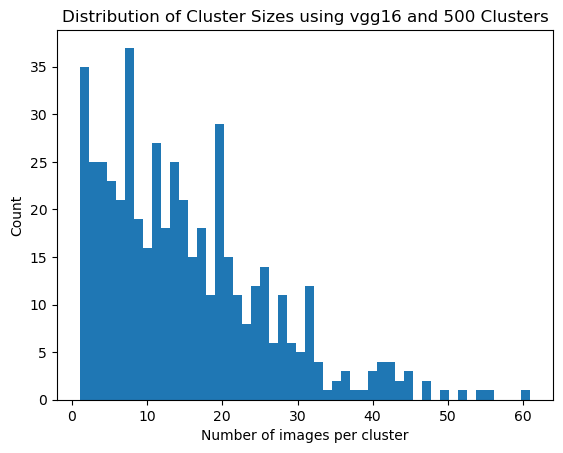

2024-02-15 10:26:50,461 - INFO - Evaluation using `target` (PVFamily_PVSubfamily) column as true labels:


Unique labels: 95


2024-02-15 10:26:50,932 - INFO - Evaluation using `PVFamily` column as true labels:


Percent of completely correct clusters: 10.07%
Percent of clusters with most frequent target frequency >= 70.0%: 41.8%
Percent of main target per cluster: 53.76%
Unique labels: 12
Percent of completely correct clusters: 18.65%
Percent of clusters with most frequent target frequency >= 70.0%: 61.4%
Percent of main target per cluster: 71.39%


,n_clusters,predicted_labels,frequency_correct_clusters,frequency_clusters_above_threshold,frequency_main_target_per_cluster
0,500,"[301, 5, 330, 67, 192, 444, 272, 420, 330, 117...",0.100686,0.418,0.537609


In [10]:
image_folder = raw_images
model_details = f'{model_name}'
target_size = pretrained_model_image_size

results_df = run(image_folder,
    model, 
    preprocess_input,
    model_details,
    target_size
    )
results_df


### Using raw images with original size

2024-02-09 04:35:50,797 - INFO - Feature matrix shape: (7578, 512)
2024-02-09 04:35:50,797 - INFO - Clustering using the full feature matrix having 512 features


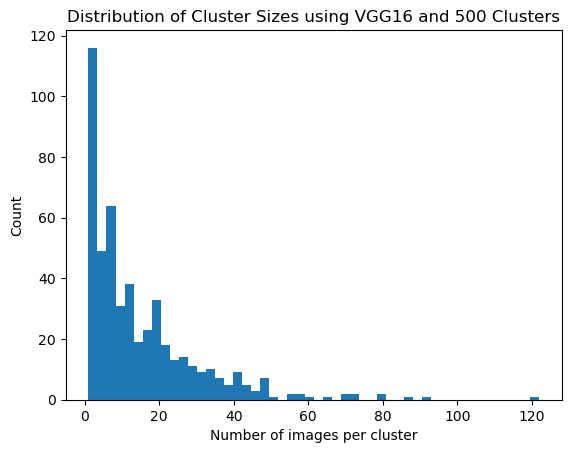

2024-02-09 04:38:11,556 - INFO - Evaluation using `target` (PVFamily_PVSubfamily) column as true labels:


Unique labels: 95


2024-02-09 04:38:12,479 - INFO - Evaluation using `PVFamily` column as true labels:


Percent of completely correct clusters: 12.23%
Percent of clusters with most frequent target frequency >= 70.0%: 49.8%
Percent of main target per cluster: 51.7%
Unique labels: 12
Percent of completely correct clusters: 18.38%
Percent of clusters with most frequent target frequency >= 70.0%: 69.6%
Percent of main target per cluster: 71.62%


In [11]:
image_folder = raw_images
model_details = f'{model_name}_original_imagesize'

results_df = run(image_folder,
    model_topless, 
    preprocess_input,
    model_details
    )
results_df

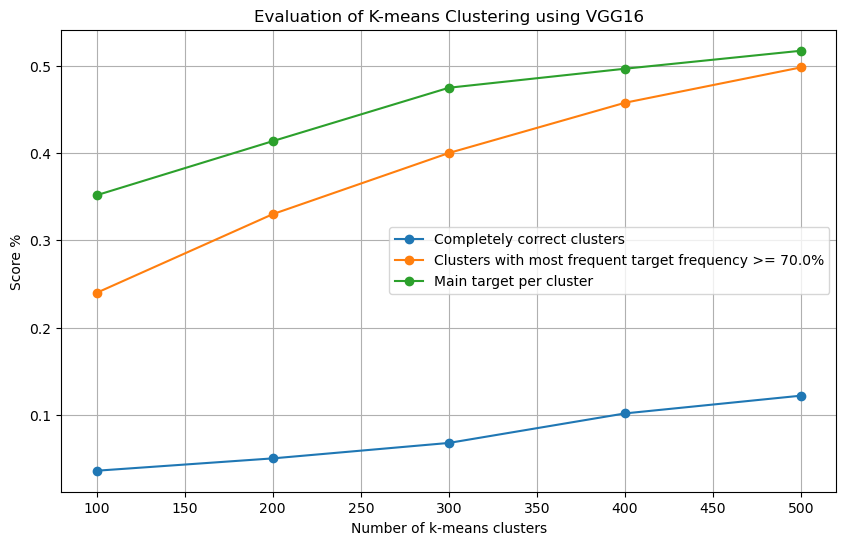

In [12]:
# Loading a presaved DataFrame with evaluation results for different number of clusters:
out_dir = os.path.join(processed_data_folder, model_details) 
results_df = pd.read_csv(os.path.join(out_dir, "evaluation.csv"))
vis.plot_score_vs_clusters_numbers(results_df, threshold, model_name)

### Using raw images with original size & PCA, 95% cumulative variance

2024-02-09 11:53:47,465 - INFO - Feature matrix shape: (7578, 512)
2024-02-09 11:53:47,467 - INFO - Finding the number of principal components explaining 95.0% of variance


Number of components for 95.0% cumulative explained variance: 147


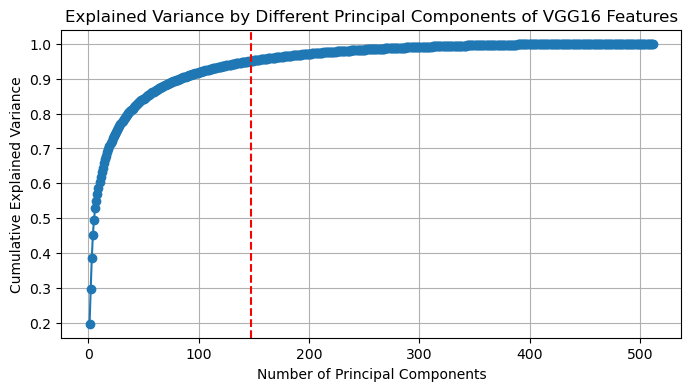

2024-02-09 11:54:09,910 - INFO - Clustering using the reduced feature matrix having 147 features into 500 clusters


Components before PCA: 512
Components after PCA: 147
Transformed feature matrix shape: (7578, 147)


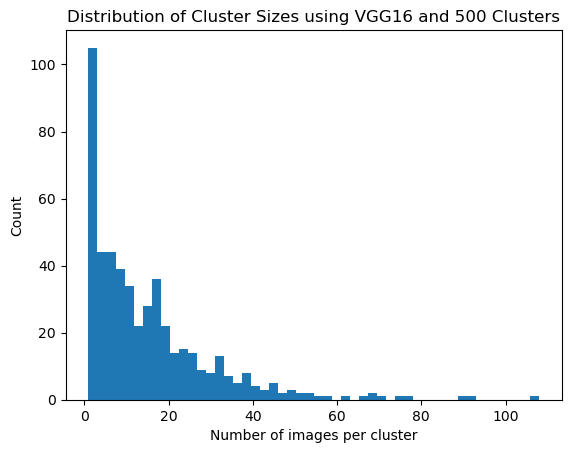

2024-02-09 11:58:50,566 - INFO - Evaluation using `target` (PVFamily_PVSubfamily) column as true labels:


Unique labels: 95


2024-02-09 11:58:51,511 - INFO - Evaluation using `PVFamily` column as true labels:


Percent of completely correct clusters: 12.19%
Percent of clusters with most frequent target frequency >= 70.0%: 48.8%
Percent of main target per cluster: 53.09%
Unique labels: 12
Percent of completely correct clusters: 20.26%
Percent of clusters with most frequent target frequency >= 70.0%: 69.6%
Percent of main target per cluster: 72.02%


,n_clusters,predicted_labels,frequency_correct_clusters,frequency_clusters_above_threshold,frequency_main_target_per_cluster
0,500,"[4, 472, 451, 444, 251, 395, 92, 207, 451, 156...",0.121932,0.488,0.530879


In [11]:
image_folder = raw_images
model_details = f'{model_name}_original_imagesize'
pca_var = 0.95

results_df = run(image_folder,
    model_topless, 
    preprocess_input,
    model_details,
    pca_var=pca_var
    )
results_df

### Using raw images with original size & grayscaling

2024-02-20 18:38:46,077 - INFO - Feature matrix shape: (7578, 512)
2024-02-20 18:38:46,079 - INFO - Clustering using the full feature matrix having 512 features


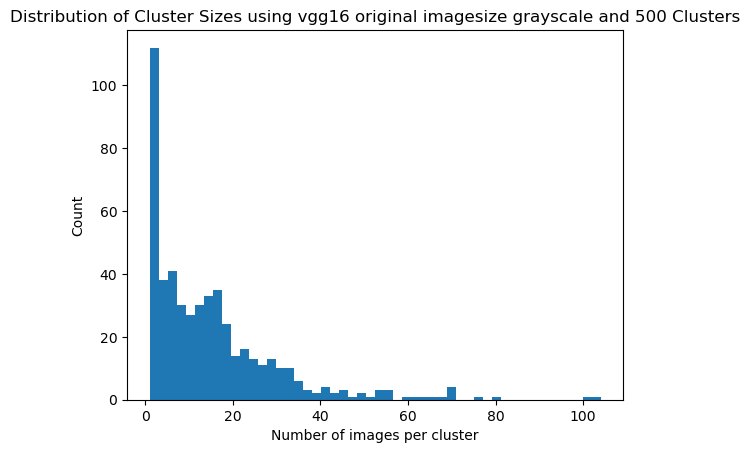

2024-02-20 18:43:51,071 - INFO - Evaluation using `target` (PVFamily_PVSubfamily) column as true labels:


Unique labels: 95


2024-02-20 18:43:51,525 - INFO - Evaluation using `PVFamily` column as true labels:


Percent of completely correct clusters: 11.49%
Percent of clusters with most frequent target frequency >= 70.0%: 49.6%
Percent of main target per cluster: 52.74%
ARI: 0.06
Unique labels: 12
Percent of completely correct clusters: 19.41%
Percent of clusters with most frequent target frequency >= 70.0%: 72.0%
Percent of main target per cluster: 71.58%
ARI: 0.01


,n_clusters,predicted_labels,frequency_correct_clusters,frequency_clusters_above_threshold,frequency_main_target_per_cluster,ari
0,500,"[18, 192, 21, 207, 48, 132, 338, 147, 191, 201...",0.114938,0.496,0.527448,0.056183


In [20]:
image_folder = raw_images
model_details = f'{model_name}_original_imagesize_grayscale'
grayscale = True

results_df = run(image_folder,
    model_topless, 
    preprocess_input,
    model_details,
    grayscale=grayscale
    )
results_df

### Using images with original size, after one segmentation round with LangSAM:
* Preclustered using image features extracted with same model, PCA with 256 principal components and KMeans using 40 clusters
* Selected 13 out of 40 clusters with noise (rulers, measuring tapes etc.)
* Ran LangSAM using "parts" prompt to leave only the part, applied the mask with the highest probability (logit) and put on white background
* Joined the segmented images with the remaining original images

2024-02-09 04:38:13,721 - INFO - Feature matrix shape: (7578, 512)
2024-02-09 04:38:13,722 - INFO - Clustering using the full feature matrix having 512 features


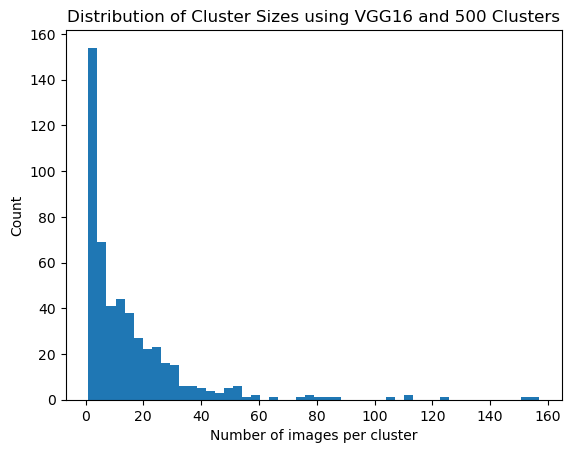

2024-02-09 04:42:02,216 - INFO - Evaluation using `target` (PVFamily_PVSubfamily) column as true labels:


Unique labels: 95
Percent of completely correct clusters: 11.59%


2024-02-09 04:42:03,199 - INFO - Evaluation using `PVFamily` column as true labels:


Percent of clusters with most frequent target frequency >= 70.0%: 52.6%
Percent of main target per cluster: 51.65%
Unique labels: 12
Percent of completely correct clusters: 21.81%
Percent of clusters with most frequent target frequency >= 70.0%: 70.6%
Percent of main target per cluster: 71.22%
100 clusters
Unique labels: 95
Percent of completely correct clusters: 3.44%
Percent of clusters with most frequent target frequency >= 70.0%: 25.0%
Percent of main target per cluster: 35.14%
200 clusters
Unique labels: 95
Percent of completely correct clusters: 5.6%
Percent of clusters with most frequent target frequency >= 70.0%: 34.5%
Percent of main target per cluster: 43.19%
300 clusters
Unique labels: 95
Percent of completely correct clusters: 8.01%
Percent of clusters with most frequent target frequency >= 70.0%: 42.67%
Percent of main target per cluster: 47.1%
400 clusters
Unique labels: 95
Percent of completely correct clusters: 9.8%
Percent of clusters with most frequent target frequenc

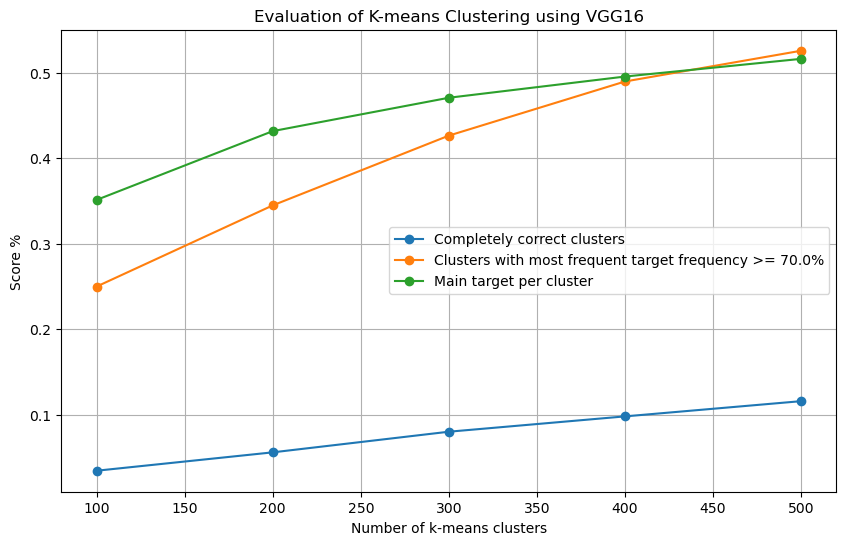

In [13]:
image_folder = segmented_images_round1
model_details = f'{model_name}_original_imagesize_segmented_part'

results_df = run(image_folder,
    model_topless,
    preprocess_input,
    model_details,
    evaluate_n_clusters=True
    )
results_df

### Using images with original size, after two segmentation rounds with LangSAM:
* First segmenation round (see above)
* Clustered the segmented images, selected badly segmented clusters
* Segmented them again using "part" prompt using area of the boxes and chosing the box with smalles area
* Joined the segmented images with the remaining original images

2024-02-15 10:41:30,752 - INFO - Preprocessing and passing each image through the predict method to get the feature vectors.
Processing image:   0%|          | 0/7578 [00:00<?, ?it/s]2024-02-15 10:41:39.461865: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-15 10:41:45.876495: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-15 10:41:45.878477: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-02-15 10:41:45.878507: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-02-15 10:41:45.880183: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. 

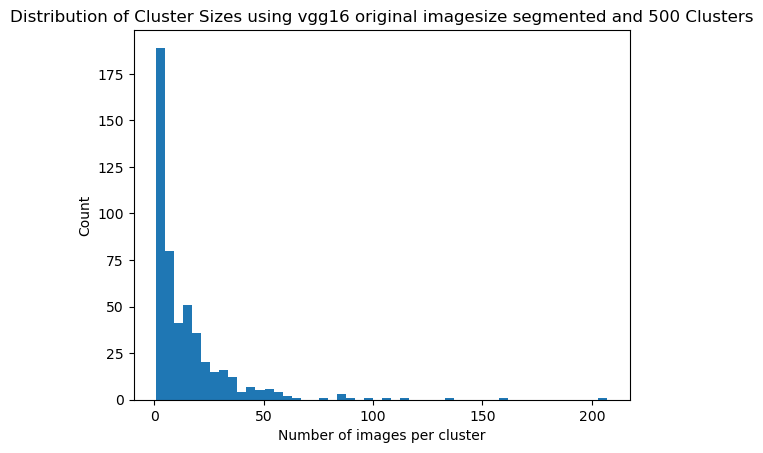

2024-02-15 10:59:09,096 - INFO - Evaluation using `target` (PVFamily_PVSubfamily) column as true labels:


Unique labels: 95
Percent of completely correct clusters: 12.75%


2024-02-15 10:59:10,000 - INFO - Evaluation using `PVFamily` column as true labels:


Percent of clusters with most frequent target frequency >= 70.0%: 56.4%
Percent of main target per cluster: 52.68%
Unique labels: 12
Percent of completely correct clusters: 21.14%
Percent of clusters with most frequent target frequency >= 70.0%: 73.0%
Percent of main target per cluster: 72.21%


,n_clusters,predicted_labels,frequency_correct_clusters,frequency_clusters_above_threshold,frequency_main_target_per_cluster
0,500,"[422, 417, 425, 486, 14, 406, 442, 149, 425, 1...",0.127474,0.564,0.526788


: 

In [11]:
image_folder = segmented_images
model_details = f'{model_name}_original_imagesize_segmented'

results_df = run(image_folder,
    model_topless,
    preprocess_input,
    model_details
    )
results_df

## Using finetuned VGG16 model with mode image dimensions using classification on our segmented data

### Model trained on 80% of images

In [9]:
# Load the model
model_details = f'{model_name}_finetuned_segmented_mode_image_dim'
model_finetuned = load_from_pickle_file(os.path.join(models_folder, f"{model_details}.pkl"))
# Remove the output layer
model_finetuned = Model(inputs=model_finetuned.inputs, outputs=model_finetuned.layers[-2].output)
model_finetuned.summary()

2024-02-14 16:17:03.638099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 16:17:03.639289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 16:17:03.640297: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 16:17:04.905306: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-14 16:17:04.905774: I external/local_xla/xla/stream_executor

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_input (InputLayer)   [(None, 353, 500, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 353, 500, 3)       0         
                                                                 
 model (Functional)          (None, 11, 15, 512)       14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 12979200 (49.51 MB)
Non-trainable params: 1735488 (6.62 MB)
_________________________________________________________________


### Rescaling into the image size of the pretrained model, after one segmentation round with LangSAM:

2024-02-14 16:17:23,192 - INFO - Feature matrix shape: (7578, 512)
2024-02-14 16:17:23,193 - INFO - Clustering using the full feature matrix having 512 features


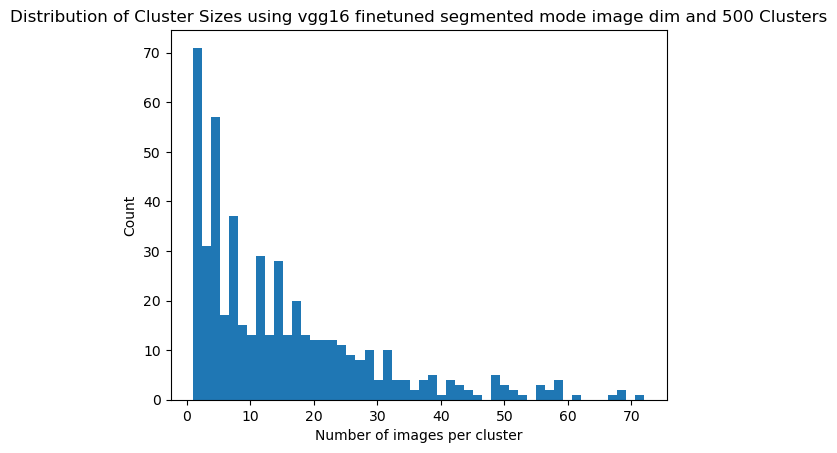

2024-02-14 16:18:20,488 - INFO - Evaluation using `target` (PVFamily_PVSubfamily) column as true labels:


Unique labels: 95


2024-02-14 16:18:20,960 - INFO - Evaluation using `PVFamily` column as true labels:


Percent of completely correct clusters: 15.1%
Percent of clusters with most frequent target frequency >= 70.0%: 55.4%
Percent of main target per cluster: 56.89%
Unique labels: 12
Percent of completely correct clusters: 20.99%
Percent of clusters with most frequent target frequency >= 70.0%: 73.8%
Percent of main target per cluster: 74.49%


,n_clusters,predicted_labels,frequency_correct_clusters,frequency_clusters_above_threshold,frequency_main_target_per_cluster
0,500,"[413, 15, 130, 285, 0, 293, 296, 164, 130, 161...",0.150963,0.554,0.568884


In [10]:
image_folder = segmented_images_round1
target_size = finetuned_model_image_size_mode

results_df = run(
    image_folder,
    model_finetuned,
    preprocess_input,
    model_details,
    target_size,
    evaluate_n_clusters=False
    )
results_df

### Model trained on 100% of images

In [15]:
# Load the model
model_details = f'{model_name}_finetuned_segmented_mode_image_dim_full_data'
model_finetuned = load_from_pickle_file(os.path.join(models_folder, f"{model_details}.pkl"))
# Remove the output layer
model_finetuned = Model(inputs=model_finetuned.inputs, outputs=model_finetuned.layers[-2].output)
model_finetuned.summary()

2024-02-14 18:33:49,077 - WARNING - Skipping variable loading for optimizer 'Adam', because it has 29 variables whereas the saved optimizer has 57 variables. 


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1_input (InputLayer  [(None, 353, 500, 3)]     0         
 )                                                               
                                                                 
 lambda_1 (Lambda)           (None, 353, 500, 3)       0         
                                                                 
 model_1 (Functional)        (None, 11, 15, 512)       14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 12979200 (49.51 MB)
Non-trainable params: 1735488 (6.62 MB)
_________________________________________________________________


In [ ]:
model_finetuned.layers[0]

### Rescaling into the image size of the pretrained model, after one segmentation round with LangSAM:

2024-02-14 18:34:26,496 - INFO - Feature matrix shape: (7578, 512)
2024-02-14 18:34:26,497 - INFO - Clustering using the full feature matrix having 512 features


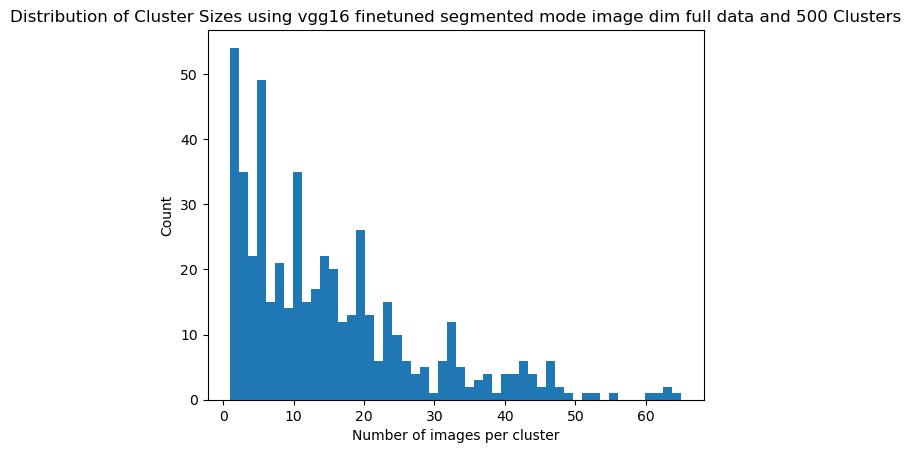

2024-02-14 18:40:42,734 - INFO - Evaluation using `target` (PVFamily_PVSubfamily) column as true labels:


Unique labels: 95


2024-02-14 18:40:43,222 - INFO - Evaluation using `PVFamily` column as true labels:


Percent of completely correct clusters: 18.29%
Percent of clusters with most frequent target frequency >= 70.0%: 54.8%
Percent of main target per cluster: 58.27%
Unique labels: 12
Percent of completely correct clusters: 25.2%
Percent of clusters with most frequent target frequency >= 70.0%: 74.4%
Percent of main target per cluster: 75.31%


,n_clusters,predicted_labels,frequency_correct_clusters,frequency_clusters_above_threshold,frequency_main_target_per_cluster
0,500,"[262, 18, 398, 86, 65, 266, 197, 165, 398, 200...",0.182898,0.548,0.58274


In [16]:
image_folder = segmented_images_round1
target_size = finetuned_model_image_size_mode

results_df = run(
    image_folder,
    model_finetuned,
    preprocess_input,
    model_details,
    target_size,
    evaluate_n_clusters=False
    )
results_df

## Using finetuned VGG16 model with mean image dimensions using classification on our segmented data

### Model trained on 100% of images, 2 segmentation rounds

In [8]:
# Load the model with last dropout layer with 256 neurons
model_details = f'{model_name}_finetuned_segmented_final_full_data'
model_finetuned = load_from_pickle_file(os.path.join(models_folder, f"{model_details}.pkl"))
# Remove the output layer
model_finetuned = Model(inputs=model_finetuned.inputs, outputs=model_finetuned.layers[-2].output)
model_finetuned.summary()

2024-02-21 12:20:33.419567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 12:20:33.420096: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 12:20:33.420468: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 12:20:35.819842: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 12:20:35.820799: I external/local_xla/xla/stream_executor

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 353, 500, 3)]     0         
                                                                 
 model (Functional)          (None, 22, 31, 512)       14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                             

In [22]:
# Load the model with GlobalAveragePooling2D with 512 neurons as last layer - like done on Kaggle
model_details = f'{model_name}_finetuned_segmented_final_full_data'
model_finetuned2 = load_from_pickle_file(os.path.join(models_folder, f"{model_details}.pkl"))
# Remove the output layer
model_finetuned2 = Model(inputs=model_finetuned2.inputs, outputs=model_finetuned2.layers[-5].output)
model_finetuned2.summary()

2024-02-21 13:42:41,691 - WARNING - Skipping variable loading for optimizer 'Adam', because it has 33 variables whereas the saved optimizer has 61 variables. 


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_input (InputLayer)    [(None, 353, 500, 3)]     0         
                                                                 
 model (Functional)          (None, 22, 31, 512)       14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 12979200 (49.51 MB)
Non-trainable params: 1735488 (6.62 MB)
_________________________________________________________________


### Rescaling into the image size of the pretrained model, after one segmentation round with LangSAM:

2024-02-14 16:32:19,782 - INFO - Feature matrix shape: (7578, 512)
2024-02-14 16:32:19,785 - INFO - Clustering using the full feature matrix having 512 features


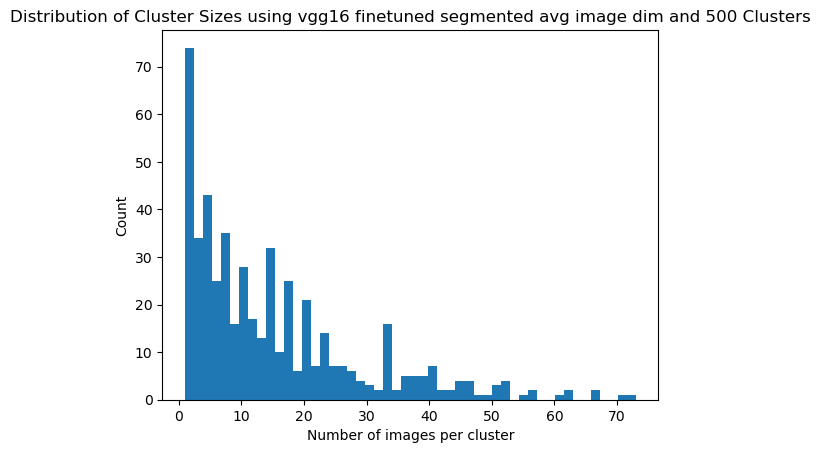

2024-02-14 16:33:07,701 - INFO - Evaluation using `target` (PVFamily_PVSubfamily) column as true labels:


Unique labels: 95


2024-02-14 16:33:08,131 - INFO - Evaluation using `PVFamily` column as true labels:


Percent of completely correct clusters: 15.81%
Percent of clusters with most frequent target frequency >= 70.0%: 56.8%
Percent of main target per cluster: 56.28%
Unique labels: 12
Percent of completely correct clusters: 24.86%
Percent of clusters with most frequent target frequency >= 70.0%: 73.6%
Percent of main target per cluster: 73.63%


,n_clusters,predicted_labels,frequency_correct_clusters,frequency_clusters_above_threshold,frequency_main_target_per_cluster
0,500,"[73, 133, 269, 131, 211, 101, 258, 207, 269, 3...",0.158089,0.568,0.562813


In [13]:
image_folder = segmented_images_round1
target_size = finetuned_model_image_size_mean

results_df = run(
    image_folder,
    model_finetuned,
    preprocess_input,
    model_details,
    target_size,
    evaluate_n_clusters=False
    )
results_df

### Rescaling into the image size of the pretrained model, after two segmentation rounds with LangSAM:

In [21]:
model_finetuned.layers[-1].name # after the last dropout layer with 256 neurons

'dropout_1'

2024-02-21 12:26:54,418 - INFO - Preprocessing and passing each image through the predict method to get the feature vectors.
Processing image:   0%|          | 0/7578 [00:00<?, ?it/s]2024-02-21 12:26:58.532800: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-21 12:27:01.164797: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-21 12:27:01.166167: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-02-21 12:27:01.166190: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-02-21 12:27:01.166233: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. 

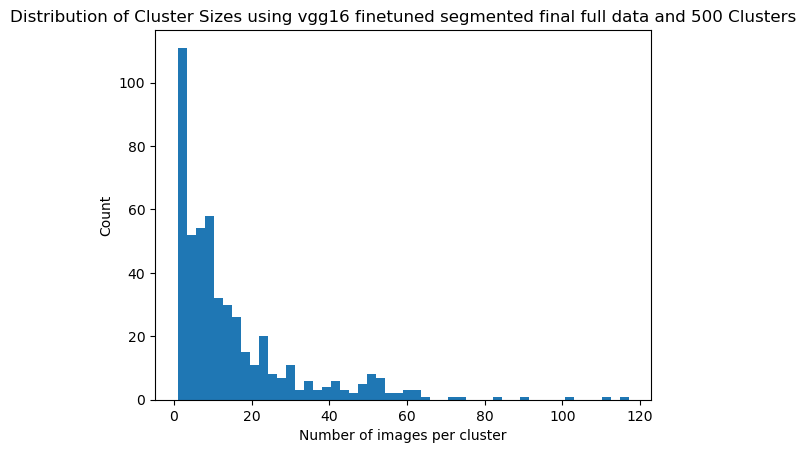

2024-02-21 12:40:29,635 - INFO - Evaluation using `target` (PVFamily_PVSubfamily) column as true labels:


Unique labels: 95


2024-02-21 12:40:30,043 - INFO - Evaluation using `PVFamily` column as true labels:


Percent of completely correct clusters: 26.47%
Percent of clusters with most frequent target frequency >= 70.0%: 76.4%
Percent of main target per cluster: 63.72%
ARI: 0.07
Unique labels: 12
Percent of completely correct clusters: 35.05%
Percent of clusters with most frequent target frequency >= 70.0%: 87.2%
Percent of main target per cluster: 78.7%
ARI: 0.01


,n_clusters,predicted_labels,frequency_correct_clusters,frequency_clusters_above_threshold,frequency_main_target_per_cluster,ari
0,500,"[131, 131, 308, 223, 4, 473, 416, 394, 308, 22...",0.264714,0.764,0.637239,0.074114


In [9]:
# With features extracted here - from last dropout layer with 256 neurons
image_folder = segmented_images
target_size = finetuned_model_image_size_mode

results_df = run(
    image_folder,
    model_finetuned,
    preprocess_input,
    model_details,
    target_size,
    evaluate_n_clusters=False
    )
results_df

In [24]:
model_finetuned2.layers[-1].name

'global_average_pooling2d'

2024-02-21 13:43:22,078 - INFO - Preprocessing and passing each image through the predict method to get the feature vectors.
Processing image: 100%|██████████| 7578/7578 [13:11<00:00,  9.57it/s]
2024-02-21 13:56:33,817 - INFO - Feature matrix shape: (7578, 512)
2024-02-21 13:56:33,819 - INFO - Clustering using the full feature matrix having 512 features


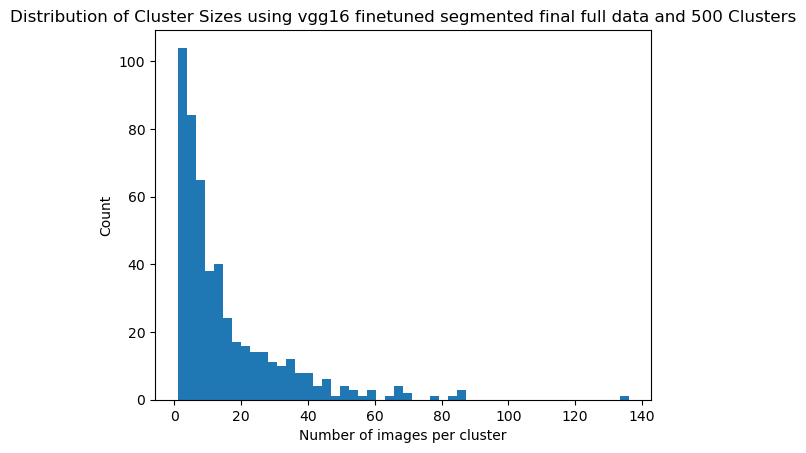

2024-02-21 14:04:51,120 - INFO - Evaluation using `target` (PVFamily_PVSubfamily) column as true labels:


Unique labels: 95


2024-02-21 14:04:51,652 - INFO - Evaluation using `PVFamily` column as true labels:


Percent of completely correct clusters: 24.69%
Percent of clusters with most frequent target frequency >= 70.0%: 70.6%
Percent of main target per cluster: 61.2%
ARI: 0.07
Unique labels: 12
Percent of completely correct clusters: 32.59%
Percent of clusters with most frequent target frequency >= 70.0%: 83.0%
Percent of main target per cluster: 77.21%
ARI: 0.01


,n_clusters,predicted_labels,frequency_correct_clusters,frequency_clusters_above_threshold,frequency_main_target_per_cluster,ari
0,500,"[427, 121, 350, 35, 141, 375, 39, 49, 350, 316...",0.246899,0.706,0.612035,0.068059


In [23]:
# With features extracted here - with GlobalAveragePooling2D
image_folder = segmented_images
target_size = finetuned_model_image_size_mode

results_df = run(
    image_folder,
    model_finetuned2,
    preprocess_input,
    model_details,
    target_size,
    evaluate_n_clusters=False
    )
results_df